# Info
Phase Shift Full Bridge Converter Design tool for battery charger.
Design for variable output voltage with limited maximum output current and power.

# QSPICE Python Files Initialization

In [1]:
import sys
import subprocess
import importlib.util

TESTED_PYTHON_VERSION = (3, 11)  # Example: tested with Python 3.11

# === Version Check ===
def check_python_version(expected_version):
    current_version = sys.version_info[:2]
    if current_version != expected_version:
        print(f"⚠️ Warning: This notebook was tested with Python {expected_version[0]}.{expected_version[1]}, "
              f"but you're running Python {current_version[0]}.{current_version[1]}.")

def check_and_install(packages):
    """
    Check if required packages are installed; install missing ones via pip.
    """
    def is_installed(pkg):
        return importlib.util.find_spec(pkg) is not None

    missing = [pkg for pkg in packages if not is_installed(pkg)]
    
    if missing:
        print(f"Installing missing packages: {missing}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
    else:
        print("✅ All required packages are installed.")

# Example usage:
required_packages = ['jinja2', 'ipympl', 'numpy', 'pandas', 'matplotlib', 'scipy', 'sympy']
check_python_version(TESTED_PYTHON_VERSION)
check_and_install(required_packages)

✅ All required packages are installed.


In [2]:
import os
import shutil

# Get the current working directory (where your script is running)
current_dir = os.getcwd()

# Define the source folder (QSPICE_Parser is located above the project directory)
source_folder = os.path.join(os.path.dirname(current_dir), 'QSPICE_Parser')

# Define the source file path
source_file = os.path.join(source_folder, 'QSPICE_parser.py')

# Define the destination folder within the project (subfolder called QSPICE)
destination_folder = os.path.join(current_dir, 'QSPICE')

# Define the destination file path (within the QSPICE subfolder)
destination_file = os.path.join(destination_folder, 'QSPICE_parser.py')

# Copy the file from source to destination
shutil.copy(source_file, destination_file)

'c:\\Users\\Stani\\OneDrive\\JupyterLab\\GitHub\\PowerElectronics_JupyterLab_QSPICE\\Phase-Shift_Full-Bridge\\QSPICE\\QSPICE_parser.py'

In [3]:
from QSPICE import QSPICE_parser
import importlib

# reload QSPICE/Python parser without kernel restart
importlib.reload(QSPICE_parser)

#Create PyQSPICE file
QSPICE_parser.parse_and_generate_script('PSFB_center_tap_closed_loop.qsch','QSPICE_PSFB_center_tap_closed_loop.py')
QSPICE_parser.parse_and_generate_script('PWM_SW_AVG_PSFB.qsch','QSPICE_PWM_SW_AVG_PSFB.py')

# Delete parser script file from QSPICE folder
os.remove(destination_file)

In [4]:
import numpy as np
import pandas as pd
import sympy as sp
import math

#from IPython.display import display, clear_output
#from IPython import display
from IPython.display import display, update_display
import time

%matplotlib ipympl
#load all QSPICE autogenerating scripts here
from QSPICE import QSPICE_PSFB_center_tap_closed_loop as QSPICE_tr
from QSPICE import QSPICE_PWM_SW_AVG_PSFB as QSPICE_ac

from IPython.display import display, Markdown, Latex
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

plt.close('all')
pd.options.display.float_format = '{:.5e}'.format

def resample(data_x, data_y, fsw):

    """
    Resample data so X data are evenly distributed.

    Parameters:
        data_x (float): X data
        data_y (float): Y data
        fsw (float): Fundamental frequency
        
    Returns:
        (x_even, waveform_resampled, sampling_rate): Returns the same resampled data and its sampling rate

    """
    duration = data_x.max() - data_x.min() # Duration of the signal in seconds
    f_max = 10*fsw # the first 10 harmonics are important
    f_sample_min = 10*2*f_max #calc. minimum samplig frequency
    Ts_max = 1/f_sample_min
    num_samples = int(duration / Ts_max)
    x_even = np.linspace(data_x.min(), data_x.max(), num_samples)  # Evenly spaced time samples

    Ts = duration/len(x_even) #calc. sampling period
    sampling_rate = 1/Ts  #calc. sampling rate
        
    # Interpolation 
    interpolator = interp1d(data_x, data_y, kind='linear')  
    waveform_resampled = interpolator(x_even)

    return x_even, waveform_resampled, sampling_rate
    

def get_Lout(N, f__s,V__d, I__L_pp,V__input,Vout__min,Vout__max):

    """
    Calculates minimum output inductor value which will ensure that I_Lout_pp < dIL_pp in whole Vout range

    Parameters:
        N (float): Transformer turn ratio (Np/Ns).
        f__s (float): Primary switching frequency.
        V__d (float): Output diode voltage drop.
        I__L_pp (float): Output inductor peak-to-peak ripple current.
        V__input (float): Input voltage.
        Vout__min (float): Minimum output voltage.
        Vout__max (float): Maximum output voltage.

    Returns:
        (Vout, Lout): Output voltage when inductor current ripple is maximal / Required minimal inductance.

    """
    x = sp.Symbol('x')
    equation = x / f__s / I__L_pp * (1 - x / (V__input / N - V__d)) / 2
    derivative = sp.diff(equation,x)
    critical_points = sp.solvers.solve(derivative, x)
    interval = (Vout__min,Vout__max)
    points_to_check = [p for p in critical_points if interval[0] <= p <= interval[1]]+list(interval)
    values = [(point,equation.subs(x,point)) for point in points_to_check]
    Vout, Lout = max(values, key=lambda item: item[1])
    
    return Vout, Lout

# one-dimensional interpolation
def EOSS_Interp(path,file_name,VDS):
    EOSS=0
    if VDS>=0 and file_name != '':
        df = pd.read_csv(path+file_name, header=None)
        
        X=df.loc[:,0].to_numpy()
        Y=df.loc[:,1].to_numpy()

        y_interp=interp1d(X, Y)
        EOSS=y_interp(VDS)
        
    else:
        EOSS=0
        

    return EOSS

# two dimensional interpolation
def EOFF_Interp(path,file_name,VDS,ID):
    EOFF=0
    if (VDS and ID >= 0) and (file_name != ''):
        df = pd.read_csv(path+file_name, header=None)

        Y=df.iloc[1:len(df.index),0].to_numpy()

        X=df.iloc[0,1:].to_numpy()

        data=df.iloc[1:,1:].to_numpy()
   
        interp = RegularGridInterpolator((Y,X),data)
        EOFF=interp((ID,VDS))
       
    else:
        EOFF=0
    
    
    return EOFF

# Input Data

In [5]:
#Input DC range
Vin_min=360
Vin_max=440
Vin_nom=400

#Output voltage range
Vout_min=172 
#Vout_nom=264.7
Vout_max=275
Vout_pp=50e-3 # Peak-to-peak Vout ripple at resistive load 

#Output power
Pout_max=900

#Output current limit
Iout_max=3.4

#Estimated efficiency
eff=0.95

#switching frequency (on the primary side, seen by switching transistor)
#note: the output inductor is switched in 2*fsw
fsw=100e3

#maximum effective secondary duty-cycle
#Note: Consider duty-cycle loss due to resonant inductor + transformer primary leakage inductance
DC_eff_max=0.82

#PWM IC duty cycle limit
DC_PWM_lim=0.95

#### Output Inductor ####
dIL_pp=1.6 #inductor peak to peak ripple current (in A)
L_out_rdc = 10e-3 #inductor rdc

#### Resonant Inductor ####
Lr = 15e-6
Lr_rdc = 10e-3 #inductor rdc

#### Transformer ####
#Estimation of transformer parasitic parameters
#Primary winding capacitance
Cp = 100e-12
#Primary leakage inductance
L_leak = 10e-6
#Primary magnetizing inductance
L_mag = 3e-3

#Vsec_k=1.24

#### MOSFET Parameters ####
#Infineon IPD60R180CM8
# VDS derating
kM=0.85
# WC rdson at 110degC
M_rdson=0.315
# Energy related Coss in F at Vin_max
Coss_ef = 30e-12

#Set MOSFET Data Folder and Eoff and Eoss file names. If empty string is provided, EOFF and EOSS energy estimation is skipped and return 0 J
# Note. It assumes that EoFF energy data are obtained using standard double-pulse test method
MOS_DATA_FLD = "Data/MOSFET/IPP60R180CM8/"
EOFF_file_name = "EOFF_IPP60R180CM8_15V_100degC_10Ohm_25ns_Ls_10nH.csv"
EOSS_file_name = "EOSS_IPP60R180CM8.csv"
#EOFF_file_name = ""
#EOSS_file_name = ""

#### Output Diodes Parameters@75degC ####
# MFR / MPN

### Output Diode ###
# Infineon IDH05G120C5@100degC
#derating factor (diode stress is kD of diode VBR rating)
kD = 0.75
D_Vfwd=0.9 # Build-in potential (in V)
D_rdiff=155e-3 # Differential resistance (in Ohm)

### Output Capacitor parameters ####
Cout = 150e-6
Cout_ESR = 280e-3


# Transformer Requirements

## Turns Ratio (Np:1)

In [6]:
Vsec_min=(Vout_max+D_Vfwd)/DC_eff_max
N=round(Vin_min/Vsec_min,2)
print(N)

1.07


# Resonant Inductor

## Maximum Duty-Cycle loss (in %)

In [7]:
DC_loss_max=DC_PWM_lim-DC_eff_max
print(round(DC_loss_max*100,2))

13.0


## Estimated Maximum Inductance of Resonant Inductor (in uH)

In [8]:
Lr_max = DC_loss_max*N*Vin_min/((Pout_max/Vout_max)*4*fsw)-L_leak
print(round(Lr_max*1e6,2))

if Lr > Lr_max:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Selected resonant inductor value is larger than Lr_max. Duty cycle loss will exceed the limit.</span></font>'))

28.25


# Output Inductor Requirements
Output inductor is calculated such as Iripple < Iripple_limit at whole Vout range. This happen when Vin is maximal

## Required Inductance (in uH)

In [9]:
Lout = get_Lout(N, fsw, D_Vfwd, dIL_pp, Vin_max, Vout_min, Vout_max)[1]
#Lout = (Pout_max/Iout_max) / fsw / dIL_pp * (1 - (Pout_max/Iout_max) / Vin_max * N) / 2
print(round(Lout*1e6,1))

320.6


## Output Voltage Leading to the Worst-Case Current Ripple (in V)
WC Lout current ripple happen at calculated Vout and Vin_max

In [10]:
Vout_WC_I_ripple = get_Lout(N, fsw, D_Vfwd, dIL_pp, Vin_max, Vout_min, Vout_max)[0]
print(round(Vout_WC_I_ripple,2))

205.16


# Output Capacitor Requirements

## Minimum Capacitance Value (in uF)
Note: This assumes that output capacitor ESR is 0 Ohm

In [11]:
Cout_min = Vout_WC_I_ripple / Lout / fsw ** 2 / Vout_pp * (1 - Vout_WC_I_ripple / (Vin_max / N - D_Vfwd)) / 32
print(round(Cout_min*1e6))

if Cout < Cout_min:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Output capacitor value is too low.</span></font>'))

20


## Maximum ESR limit (in mOhm)
Note: This assumes that output capacitance is infinity

In [12]:
Cout_ESR_max = Vout_pp/dIL_pp
print(round(Cout_ESR_max*1000))

if Cout_ESR_max < Cout_ESR:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Output capacitor ESR is too high.</span></font>'))


31


<font size="6"> <span style="color:red"> Warning: Output capacitor ESR is too high.</span></font>

## Estimated Equivalent Electrolytical Capacitor (in uF)
Note: Based on assumption that relationship between the capacitance and ESR of an
electrolytic capacitor is C ⋅ ESR = 60e-6

In [13]:
Cout_elyt = 60e-6/Cout_ESR_max
print(round(Cout_elyt*1e6))

1920


# Stress Analysis (Worst-Case Calculation)

In [14]:
Vin = Vin_max
Vout = Vout_WC_I_ripple 
Pout_lim = Pout_max
fc = fsw*2/50

results_AC_sim = QSPICE_ac.QSPICE_PWM_SW_AVG_PSFB(Cout, Cout_ESR, fc, fsw, Iout_max, Lout, N, Pout_lim, Vin, Vout)

Gfc = results_AC_sim[1]["TF_gain"]
PS = results_AC_sim[1]["TF_phase"]
ks = results_AC_sim[1]["ks"]
kr = results_AC_sim[1]["kr"]

deadtime = 100e-9

results_tr_sim = QSPICE_tr.QSPICE_PSFB_center_tap_closed_loop(Cout, Cout_ESR, D_rdiff, D_Vfwd, deadtime, eff, fc, fsw, Gfc, Iout_max, kr, ks, L_leak, L_mag, L_out_rdc, Lout, Lr, Lr_rdc, M_rdson, N, Pout_max, PS, Vin, Vout, "I(L1),I(L3),I(Lout)")

I_Lsec2_RMS = results_tr_sim[1]["I_Lsec2_RMS"]
I_Lsec2_AVG = results_tr_sim[1]["I_Lsec2_AVG"]
I_Lprim_RMS = results_tr_sim[1]["I_Lprim_RMS"]
I_Lprim_pp = results_tr_sim[1]["I_Lprim_pp"]
I_Lout_RMS = results_tr_sim[1]["I_Lout_RMS"]
I_Lout_PP = results_tr_sim[1]["I_Lout_PP"]
I_Lout_AVG = results_tr_sim[1]["I_Lout_AVG"]
I_S2_RMS = results_tr_sim[1]["I_S2_RMS"]
I_S1_RMS = results_tr_sim[1]["I_S1_RMS"]
I_S2_peak = results_tr_sim[1]["I_S2_peak"]
I_S1_peak = results_tr_sim[1]["I_S1_peak"]
I_Lres_ZVS_Vin_max_Lout_WC_ripple = results_tr_sim[1]["L_res_point"]

wfrm = results_tr_sim[0]



print("Vin_min, Vout_nom")

Vin = Vin_min
Vout = Pout_max/Iout_max #nominal Vout 
Pout_lim = Pout_max
fc = fsw*2/50

results_AC_sim = QSPICE_ac.QSPICE_PWM_SW_AVG_PSFB(Cout, Cout_ESR, fc, fsw, Iout_max, Lout, N, Pout_lim, Vin, Vout)

Gfc = results_AC_sim[1]["TF_gain"]
PS = results_AC_sim[1]["TF_phase"]
ks = results_AC_sim[1]["ks"]
kr = results_AC_sim[1]["kr"]

deadtime = 100e-9

results_tr_sim = QSPICE_tr.QSPICE_PSFB_center_tap_closed_loop(Cout, Cout_ESR, D_rdiff, D_Vfwd, deadtime, eff, fc, fsw, Gfc, Iout_max, kr, ks, L_leak, L_mag, L_out_rdc, Lout, Lr, Lr_rdc, M_rdson, N, Pout_max, PS, Vin, Vout, "I(L1),I(L3)")


I_sense_RMS = results_tr_sim[1]["I_sense_RMS"]
I_Lres_ZVS_Vin_min_Vout_nom = results_tr_sim[1]["L_res_point"]

#print("Vin_max, Vout_nom")
#test = find_OP(Coss_ef, Cout_ESR, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_max,Pout_max/Iout_max)

#print("Vin_max, Vout_max")
#test = find_OP(Coss_ef, Cout_ESR, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_max,Vout_max)

#print("Vin_min, Vout_WC_ripple")
#test = find_OP(Coss_ef, Cout_ESR, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_min,Vout_WC_I_ripple)

#print("Vin_min, Vout_max")
#test = find_OP(Coss_ef, Cout_ESR, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_min,Vout_max)




C:\Users\Stani\OneDrive\JupyterLab\GitHub\PowerElectronics_JupyterLab_QSPICE\Phase-Shift_Full-Bridge\QSPICE\PWM_SW_AVG_PSFB.cir
Starting Gmin stepping.
Starting source stepping.
Source step succeeded.

Total elapsed time: 0.044253 seconds.
QSPICE64 simulation completed successfully.
*************** END ***************
C:\Users\Stani\OneDrive\JupyterLab\GitHub\PowerElectronics_JupyterLab_QSPICE\Phase-Shift_Full-Bridge\QSPICE\PSFB_center_tap_closed_loop.cir

Total elapsed time: 12.3456 seconds.
QSPICE64 simulation completed successfully.
*************** END ***************
Vin_min, Vout_nom
C:\Users\Stani\OneDrive\JupyterLab\GitHub\PowerElectronics_JupyterLab_QSPICE\Phase-Shift_Full-Bridge\QSPICE\PWM_SW_AVG_PSFB.cir
Starting Gmin stepping.
Starting source stepping.
Source step succeeded.

Total elapsed time: 0.0441684 seconds.
QSPICE64 simulation completed successfully.
*************** END ***************
C:\Users\Stani\OneDrive\JupyterLab\GitHub\PowerElectronics_JupyterLab_QSPICE\Phase-

## Secondary Switch VBR Requirement > (in V)
Note: Derating factor is included

In [15]:
VBR_sec = ((2*Vin_max)/N)/kD
print(round(VBR_sec,0))

1097.0


## Secondary Winding RMS Current (in A)
Note: The same current flow through secondary switch

In [16]:
print(I_Lsec2_RMS)

2.40892


## Secondary Winding AVG Current (in A)
Note: The same current flow through secondary switch

In [17]:
print(I_Lsec2_AVG)

1.70036


## Secondary Winding Current (FFT Spectrum)

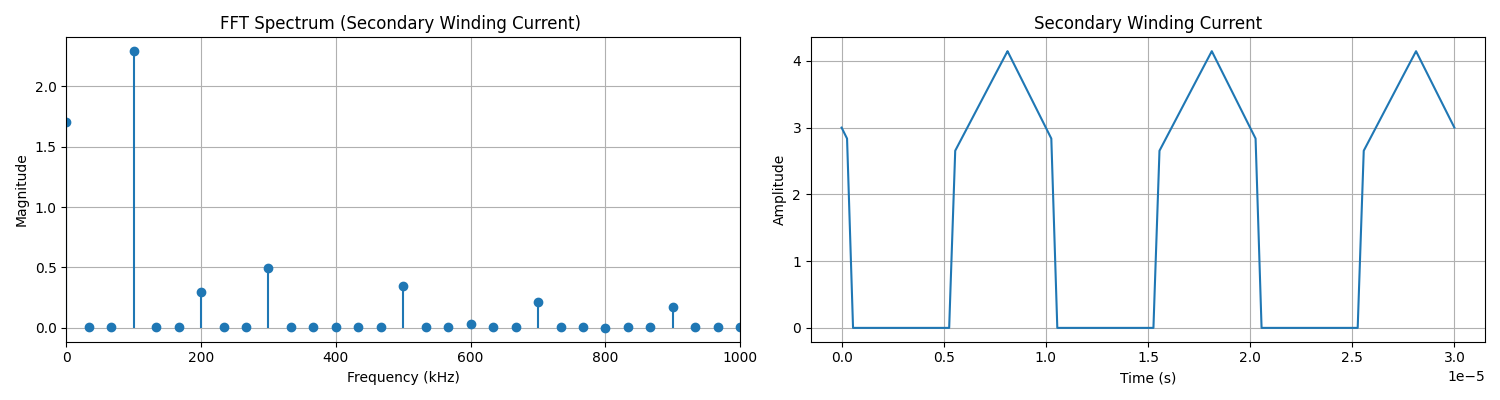

,Harmonic,Frequency (kHz),Magnitude,Unit
0,DC Component,0.000,1.7025,AVG
1,1 (Harmonic),100.003,1.6189,RMS
2,2 (Harmonic),200.007,0.2101,RMS
3,3 (Harmonic),300.010,0.3500,RMS
4,4 (Harmonic),400.013,0.0036,RMS
5,5 (Harmonic),500.017,0.2449,RMS
6,6 (Harmonic),600.020,0.0213,RMS
7,7 (Harmonic),700.023,0.1541,RMS
8,8 (Harmonic),800.027,0.0018,RMS
9,9 (Harmonic),900.030,0.1207,RMS


In [18]:
time_uneven = wfrm["time"]  
waveform = wfrm["i(l3)"] 

# Resample data for FFT
time_resampled, waveform_resampled, sampling_rate = resample(wfrm["time"], wfrm["i(l3)"], fsw)

# Perform FFT
fft_values = rfft(waveform_resampled)
num_samples = len(time_resampled)
freq = rfftfreq(num_samples, d=1/sampling_rate)
norm_amplitude = np.abs(fft_values)/num_samples
norm_amplitude[1:] *= 2 # DC component is not mirrored

# Find index of the fundamental frequency
fundamental_idx = np.argmin(np.abs(freq - fsw))

# Extract the first 10 harmonics
harmonic_indices = [0] + [fundamental_idx * n for n in range(1, 11)]
harmonic_frequencies = freq[harmonic_indices]/1000
harmonic_magnitudes_rms = np.concatenate(([norm_amplitude[0]], norm_amplitude[harmonic_indices[1:11]] / np.sqrt(2)))

# Create a DataFrame for the results
harmonics_table = pd.DataFrame({
    "Harmonic": ["DC Component"] + [f"{n} (Harmonic)" for n in range(1, 11)],
    "Frequency (kHz)": harmonic_frequencies,
    "Magnitude": harmonic_magnitudes_rms
})

harmonics_table["Unit"] = ["AVG"]+ ["RMS"] * 10

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the spectrum
ax[0].stem(freq / 1000, norm_amplitude, basefmt=" ", label="FFT Spectrum")
#axes[0].scatter(harmonic_frequencies, harmonic_magnitudes_rms, color="red", label="Harmonics")
ax[0].set_title("FFT Spectrum (Secondary Winding Current) ")
ax[0].set_xlabel("Frequency (kHz)")
ax[0].set_ylabel("Magnitude")
ax[0].set_xlim(0, np.max(harmonic_frequencies) + 0.1)  # Limit x-axis to harmonics range
ax[0].grid()

# Create a second plot (for example, a simple sine wave) on the second axis (ax[1])
ax[1].plot(time_uneven, waveform)
ax[1].set_title("Secondary Winding Current")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

# Display the table in Jupyter Notebook
display(harmonics_table.style.format({"Frequency (kHz)": "{:.3f}", "Magnitude": "{:.4f}"}))

## Output Inductor

### Peak Current (in A)

In [19]:
print(round(I_Lout_AVG+I_Lout_PP/2,2))

4.15


### RMS Current (in A)

In [20]:
print(round(I_Lout_RMS,2))

3.43


### Output Inductor Current (FFT Spectrum)

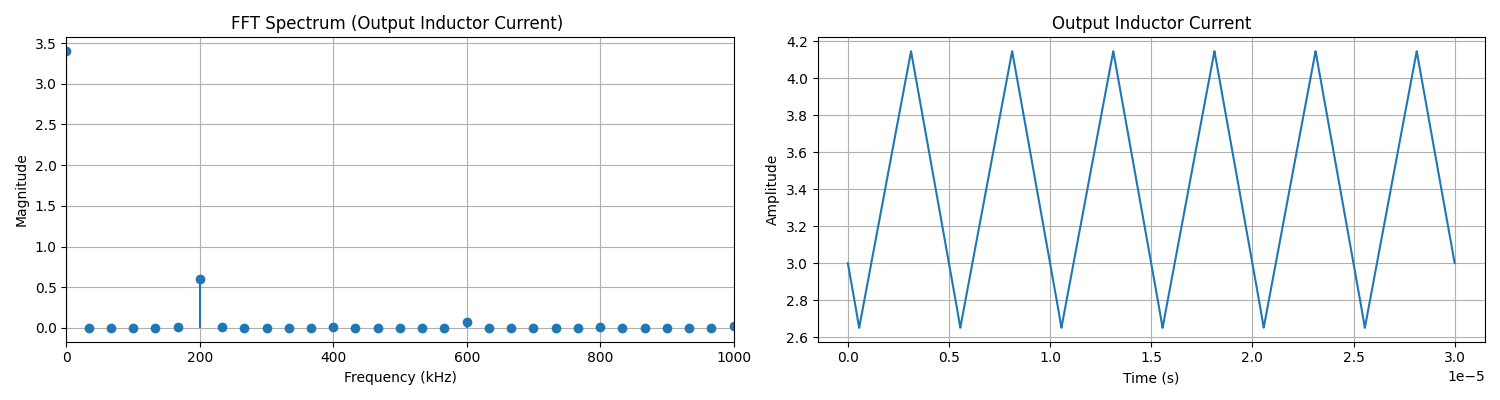

,Harmonic,Frequency (kHz),Magnitude,Unit
0,DC Component,0.000,3.4001,AVG
1,1 (Harmonic),100.003,0.0013,RMS
2,2 (Harmonic),200.007,0.4269,RMS
3,3 (Harmonic),300.010,0.0014,RMS
4,4 (Harmonic),400.013,0.0071,RMS
5,5 (Harmonic),500.017,0.0006,RMS
6,6 (Harmonic),600.020,0.0473,RMS
7,7 (Harmonic),700.023,0.0007,RMS
8,8 (Harmonic),800.027,0.0034,RMS
9,9 (Harmonic),900.030,0.0006,RMS


In [21]:
time_uneven = wfrm["time"]  
waveform = wfrm["i(lout)"] 

# Resample data for FFT
time_resampled, waveform_resampled, sampling_rate = resample(wfrm["time"], wfrm["i(lout)"], fsw)

# Perform FFT
fft_values = rfft(waveform_resampled)
num_samples = len(time_resampled)
freq = rfftfreq(num_samples, d=1/sampling_rate)
norm_amplitude = np.abs(fft_values)/num_samples
norm_amplitude[1:] *= 2 # DC component is not mirrored

# Find index of the fundamental frequency
fundamental_idx = np.argmin(np.abs(freq - fsw))

# Extract the first 10 harmonics
harmonic_indices = [0] + [fundamental_idx * n for n in range(1, 11)]
harmonic_frequencies = freq[harmonic_indices]/1000
harmonic_magnitudes_rms = np.concatenate(([norm_amplitude[0]], norm_amplitude[harmonic_indices[1:11]] / np.sqrt(2)))

# Create a DataFrame for the results
harmonics_table = pd.DataFrame({
    "Harmonic": ["DC Component"] + [f"{n} (Harmonic)" for n in range(1, 11)],
    "Frequency (kHz)": harmonic_frequencies,
    "Magnitude": harmonic_magnitudes_rms
})

harmonics_table["Unit"] = ["AVG"]+ ["RMS"] * 10

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the spectrum
ax[0].stem(freq / 1000, norm_amplitude, basefmt=" ", label="FFT Spectrum")
#axes[0].scatter(harmonic_frequencies, harmonic_magnitudes_rms, color="red", label="Harmonics")
ax[0].set_title("FFT Spectrum (Output Inductor Current) ")
ax[0].set_xlabel("Frequency (kHz)")
ax[0].set_ylabel("Magnitude")
ax[0].set_xlim(0, np.max(harmonic_frequencies) + 0.1)  # Limit x-axis to harmonics range
ax[0].grid()

# Create a second plot (for example, a simple sine wave) on the second axis (ax[1])
ax[1].plot(time_uneven, waveform)
ax[1].set_title("Output Inductor Current")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

# Display the table in Jupyter Notebook
display(harmonics_table.style.format({"Frequency (kHz)": "{:.3f}", "Magnitude": "{:.4f}"}))

## Primary Winding RMS Current (in A)
Note. The same current flows through resonant inductor

In [22]:
print(round(I_Lprim_RMS,2))

3.25


## Primary Winding Current (FFT Spectrum)

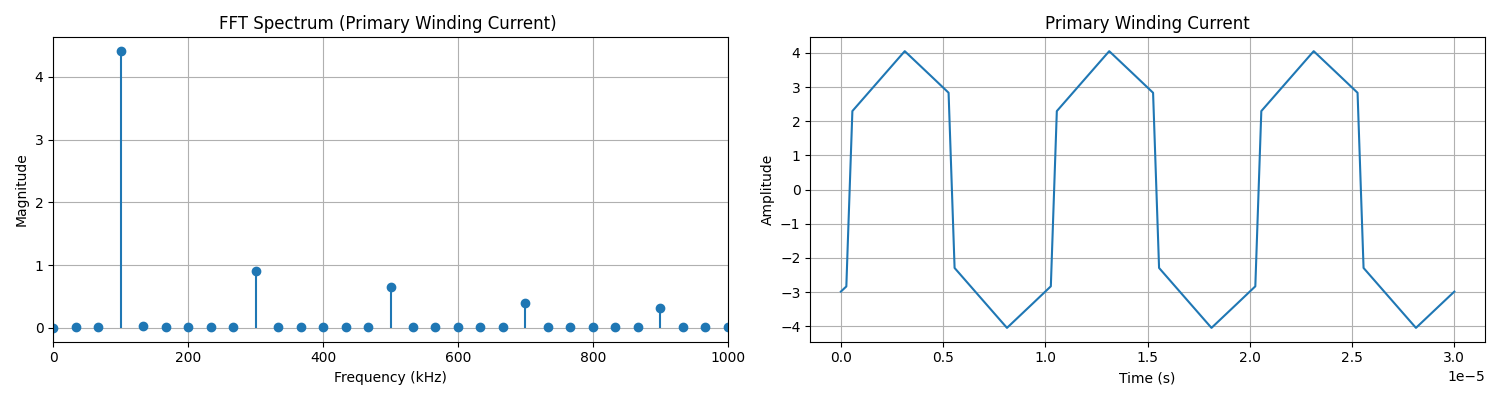

,Harmonic,Frequency (kHz),Magnitude,Unit
0,DC Component,0.000,0.0049,AVG
1,1 (Harmonic),100.003,3.1191,RMS
2,2 (Harmonic),200.007,0.0063,RMS
3,3 (Harmonic),300.010,0.6411,RMS
4,4 (Harmonic),400.013,0.0063,RMS
5,5 (Harmonic),500.017,0.4590,RMS
6,6 (Harmonic),600.020,0.0055,RMS
7,7 (Harmonic),700.023,0.2856,RMS
8,8 (Harmonic),800.027,0.0057,RMS
9,9 (Harmonic),900.030,0.2247,RMS


In [23]:
time_uneven = wfrm["time"]  
waveform = wfrm["i(l1)"] 

# Resample data for FFT
time_resampled, waveform_resampled, sampling_rate = resample(wfrm["time"], wfrm["i(l1)"], fsw)

# Perform FFT
fft_values = rfft(waveform_resampled)
num_samples = len(time_resampled)
freq = rfftfreq(num_samples, d=1/sampling_rate)
norm_amplitude = np.abs(fft_values)/num_samples
norm_amplitude[1:] *= 2 # DC component is not mirrored

# Find index of the fundamental frequency
fundamental_idx = np.argmin(np.abs(freq - fsw))

# Extract the first 10 harmonics
harmonic_indices = [0] + [fundamental_idx * n for n in range(1, 11)]
harmonic_frequencies = freq[harmonic_indices]/1000
harmonic_magnitudes_rms = np.concatenate(([norm_amplitude[0]], norm_amplitude[harmonic_indices[1:11]] / np.sqrt(2)))

# Create a DataFrame for the results
harmonics_table = pd.DataFrame({
    "Harmonic": ["DC Component"] + [f"{n} (Harmonic)" for n in range(1, 11)],
    "Frequency (kHz)": harmonic_frequencies,
    "Magnitude": harmonic_magnitudes_rms
})

harmonics_table["Unit"] = ["AVG"]+ ["RMS"] * 10

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the spectrum
ax[0].stem(freq / 1000, norm_amplitude, basefmt=" ", label="FFT Spectrum")
#axes[0].scatter(harmonic_frequencies, harmonic_magnitudes_rms, color="red", label="Harmonics")
ax[0].set_title("FFT Spectrum (Primary Winding Current) ")
ax[0].set_xlabel("Frequency (kHz)")
ax[0].set_ylabel("Magnitude")
ax[0].set_xlim(0, np.max(harmonic_frequencies) + 0.1)  # Limit x-axis to harmonics range
ax[0].grid()

# Create a second plot (for example, a simple sine wave) on the second axis (ax[1])
ax[1].plot(time_uneven, waveform)
ax[1].set_title("Primary Winding Current")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

# Display the table in Jupyter Notebook
display(harmonics_table.style.format({"Frequency (kHz)": "{:.3f}", "Magnitude": "{:.4f}"}))

## Primary Winding Peak-Peak Current (in A)
Note: The same current flows through resonant inductor. Primary winding AVG current is 0

In [24]:
print(I_Lprim_pp)

8.10008


## MOSFET RMS Current (Leading Leg) / per MOSFET (in A)

In [25]:
print(round(I_S1_RMS,2))

2.08


## MOSFET RMS Current (Lagging Leg) / per MOSFET (in A)

In [26]:
print(round(I_S2_RMS,2))

2.29


# ZVS Range

## Required energy to achieve ZVS (in uJ)

In [27]:
E_TR = 0.5* Cp*Vin_max*Vin_max
E_Coss = (0.5*Coss_ef*Vin_max*Vin_max)*2
E_ZVS=E_TR+E_Coss
print(round(E_ZVS*1e6,2))

15.49


## Achieved Energy for ZVS Under Various Operating Conditions

In [28]:
#print("Estimated energy@Vin_max/Vout@Lout_WC_ripple:",round((0.5*(Lr_max + L_leak)*I_Lres_ZVS_Vin_max_Lout_WC_ripple**2)*1e6,2))
#print(I_Lres_ZVS_Vin_max_Lout_WC_ripple)
#print("\n")


#print("Estimated energy@Vin_min/Vout_nom:",round((0.5*(Lr_max + L_leak)*I_Lres_ZVS_Vin_min_Vout_nom**2)*1e6,2))
#print(I_Lres_ZVS_Vin_min_Vout_nom)
#print("\n")

ZVS_operating_range = False
if (ZVS_operating_range):
    percentages = [0.25, 0.50, 0.75, 1]
    results_Vout_nom = []  # List to store the results
    results_Vout_min = []  # List to store the results
    results_Vout_max = []  # List to store the results
    #Vout_nom = Pout_max/Iout_max

    for Pout_perc in percentages:
        Vin = Vin_nom
        Vout = Pout_max/Iout_max 
        Pout_lim = Pout_max * Pout_perc
        fc = fsw*2/50

        results_AC_sim = QSPICE_ac.QSPICE_PWM_SW_AVG_PSFB(Cout, Cout_ESR, fc, fsw, Iout_max, Lout, N, Pout_lim, Vin, Vout)

        Gfc = results_AC_sim[1]["TF_gain"]
        PS = results_AC_sim[1]["TF_phase"]
        ks = results_AC_sim[1]["ks"]
        kr = results_AC_sim[1]["kr"]

        
        deadtime = 100e-9

        #print("Vin = ",Vin,"\n")
        #print("Vout = ",Vout,"\n")
        #print("Pout_lim = ",Pout_lim,"\n")
        #print("fc = ", fc,"\n")
        #print("Gfc = ",Gfc,"\n")
        #print("PS = ",PS,"\n")
        #print("ks = ",ks,"\n")
        #print("kr = ",kr,"\n")
        #print("\n\n\n")



        results_tr_sim = QSPICE_tr.QSPICE_PSFB_center_tap_closed_loop(Cout, Cout_ESR, D_rdiff, D_Vfwd, deadtime, eff, fc, fsw, Gfc, Iout_max, kr, ks, L_leak, L_mag, L_out_rdc, Lout, Lr, Lr_rdc, M_rdson, N, Pout_lim, PS, Vin, Vout, "I(L1),I(L3)")

        #result = results_tr_sim[1]
        #results_Vin_nom.append(0.5*(L_leak+Lr)*(results_tr_sim[1]["L_res_point"])**2)
        results_Vout_nom.append(0.5*(L_leak+Lr)*results_tr_sim[1]["L_res_point"]**2)

    #print(results_Vin_nom)    

    for Pout_perc in percentages:
        Vin = Vin_nom
        Vout = Vout_min 
        Pout_lim = Pout_max * Pout_perc
        fc = fsw*2/50

        results_AC_sim = QSPICE_ac.QSPICE_PWM_SW_AVG_PSFB(Cout, Cout_ESR, fc, fsw, Iout_max, Lout, N, Pout_lim, Vin, Vout)

        Gfc = results_AC_sim[1]["TF_gain"]
        PS = results_AC_sim[1]["TF_phase"]
        ks = results_AC_sim[1]["ks"]
        kr = results_AC_sim[1]["kr"]

        deadtime = 100e-9

        results_tr_sim = QSPICE_tr.QSPICE_PSFB_center_tap_closed_loop(Cout, Cout_ESR, D_rdiff, D_Vfwd, deadtime, eff, fc, fsw, Gfc, Iout_max, kr, ks, L_leak, L_mag, L_out_rdc, Lout, Lr, Lr_rdc, M_rdson, N, Pout_lim, PS, Vin, Vout, "I(L1),I(L3)")

        #result = results_tr_sim[1]
        results_Vout_min.append(0.5*(L_leak+Lr)*(results_tr_sim[1]["L_res_point"])**2)

    for Pout_perc in percentages:
        Vin = Vin_nom
        Vout = Vout_max
        Pout_lim = Pout_max * Pout_perc
        fc = fsw*2/50

        results_AC_sim = QSPICE_ac.QSPICE_PWM_SW_AVG_PSFB(Cout, Cout_ESR, fc, fsw, Iout_max, Lout, N, Pout_lim, Vin, Vout)

        Gfc = results_AC_sim[1]["TF_gain"]
        PS = results_AC_sim[1]["TF_phase"]
        ks = results_AC_sim[1]["ks"]
        kr = results_AC_sim[1]["kr"]

        deadtime = 100e-9

        results_tr_sim = QSPICE_tr.QSPICE_PSFB_center_tap_closed_loop(Cout, Cout_ESR, D_rdiff, D_Vfwd, deadtime, eff, fc, fsw, Gfc, Iout_max, kr, ks, L_leak, L_mag, L_out_rdc, Lout, Lr, Lr_rdc, M_rdson, N, Pout_lim, PS, Vin, Vout, "I(L1),I(L3)")

        #result = results_tr_sim[1]
        results_Vout_max.append(0.5*(L_leak+Lr)*(results_tr_sim[1]["L_res_point"])**2)

    print([x* 1e6 for x in results_Vout_nom])       




In [29]:
#energy_results = [(round((0.5*(Lr_max + L_leak)*value**2)*1e6,2)) for value in results]
#print(energy_results)

# Losses Estimation

## Output Diode / per diode (in W)
Note: Center tap uses 2 diodes

In [30]:
P_diode1_cond=I_Lsec2_AVG*D_Vfwd + D_rdiff * I_Lsec2_RMS**2 
round(P_diode1_cond,2)

2.43

## MOSFET

### Conduction Losses / per switch (Leading leg) (in W)

In [31]:
P_FET1_Cond = M_rdson * I_S1_RMS**2
round(P_FET1_Cond,2)

1.37

### Switching Losses / per switch (Leading leg) (in W)

In [32]:
P_FET1_SW = (EOFF_Interp(MOS_DATA_FLD,EOFF_file_name,Vin_max,I_S1_peak)-EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,Vin_max))*fsw
print(round(P_FET1_SW,3))

0.093


### Conduction Losses / per switch (Lagging leg) (in W)

In [33]:
P_FET2_Cond = M_rdson * I_S2_RMS**2
round(P_FET2_Cond,2)

1.65

### Switching Losses / per switch (Lagging leg) (in W)

In [34]:
#print(EOFF_Interp(MOS_DATA_FLD,EOFF_file_name,Vin_max,I_Lprim_pp/2))
#print(EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,Vin_max))

P_FET2_SW = (EOFF_Interp(MOS_DATA_FLD,EOFF_file_name,Vin_max,I_S2_peak)-EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,Vin_max))*fsw
print(round(P_FET2_SW,3))


0.093


# Estimated Total Converter Losses Without Magnetic Losses

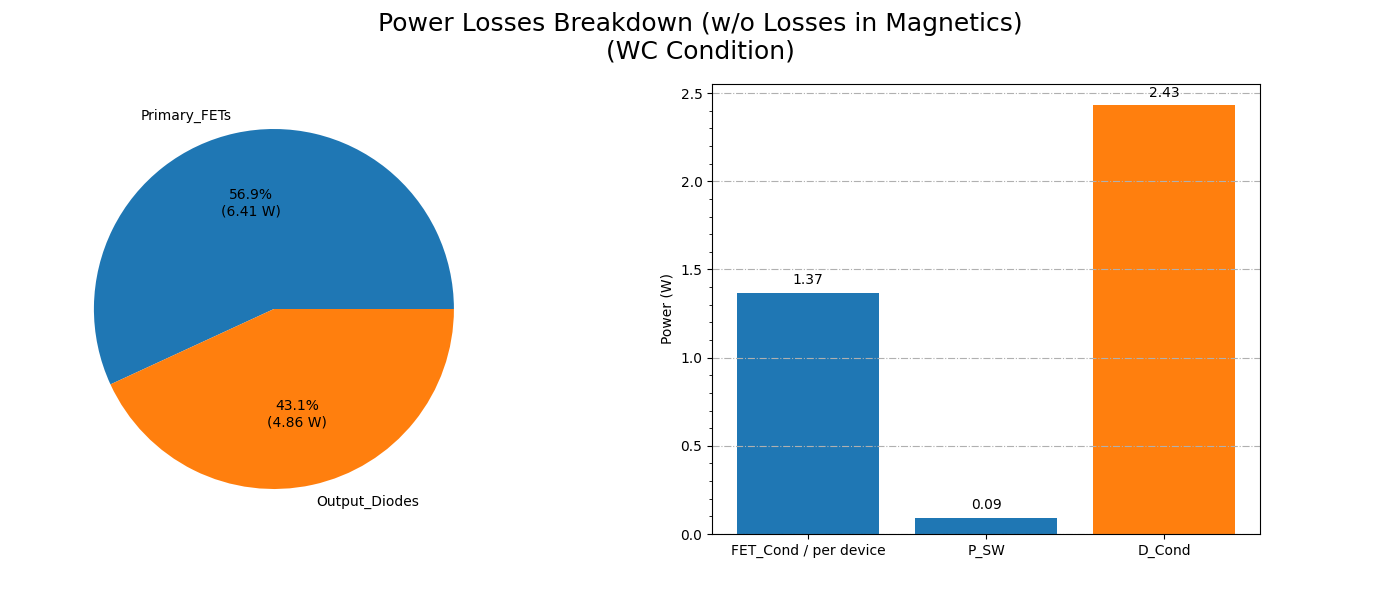

In [35]:
labels_Ploss= 'Primary_FETs', 'Output_Diodes'
data_Ploss = [P_FET1_Cond*2+P_FET2_Cond*2+P_FET1_SW*2+P_FET2_SW*2, P_diode1_cond*2]

labels_Ploss_Bar= 'FET_Cond / per device', 'P_SW', 'D_Cond'
data_Ploss_Bar = [P_FET1_Cond, P_FET1_SW, P_diode1_cond]

#bar_labels = ['red', 'blue', '_red', 'orange','green']
bar_colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green','tab:red', 'tab:red']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = round(pct*total/100,3)
            return '{:.1f}%\n({v:.2f} W)'.format(pct, v=val)
        return my_format

def addlabels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+0.05, round(y[i],2), ha = 'center')
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
#fig, (ax1, ax2) = plt.subplots(1, 2)
#fig, ax1 = plt.subplots()

if MOS_DATA_FLD != "":
    fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics)'+'\n'+'(WC Condition)',fontsize=18)
else:
    fig.suptitle('Power Losses Breakdown (w/o MOSFET SW Losses and Losses in Magnetics)'+'\n'+'(WC Condition)',fontsize=18)
ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))

ax2.bar(labels_Ploss_Bar, data_Ploss_Bar,color=bar_colors)
ax2.grid(True, linestyle='-.',axis='y')
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_ylabel('Power (W)')
addlabels(labels_Ploss_Bar,data_Ploss_Bar)

fig.subplots_adjust(left = 0, top=0.86, wspace = 0.3)
#fig.subplots_adjust(left=0.05, right=0.95, wspace=0.2)

plt.show()
if MOS_DATA_FLD == "":
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Primary MOSFET switching losses are available only when DPT energy data are provided.</span></font>'))

In [36]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

%matplotlib ipympl

# Load data (assuming CSV with 'Frequency' and 'Gain' columns)
def load_data(data_file):
    return pd.read_csv(data_file)

# Compute numerical derivative (slope)
def compute_slope(frequency, gain):
    log_freq = np.log10(frequency)
    return np.gradient(gain, log_freq)

# Find frequency range with -20 dB/decade slope
def find_slope_range(frequency, slopes, target_slope=-20, tolerance=2):
    valid_indices = np.where((slopes >= target_slope - tolerance) & (slopes <= target_slope + tolerance))[0]
    if valid_indices.size > 0:
        start_idx = valid_indices[0]
        end_idx = start_idx
        
        for idx in valid_indices[1:]:
            if idx == end_idx + 1:
                end_idx = idx
    
        return frequency[start_idx], frequency[end_idx]
    return None

# Plot results
def plot_results(frequency, gain, slopes):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.semilogx(frequency, gain, label='Gain (dB)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain (dB)')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.semilogx(frequency, slopes, label='Slope (dB/decade)', color='r')
    plt.axhline(-20, color='k', linestyle='--', label='-20 dB/dec')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Slope (dB/decade)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main execution cell
data_file = 'Vout_vs_Vc_AC-Gain2.csv'  # Replace with actual file path
df = load_data(data_file)
frequency = df['Frequency'].values
gain = df['Gain'].values

slopes = compute_slope(frequency, gain)
freq_range = find_slope_range(frequency, slopes)

if freq_range:
    print(f"Frequency range with -20 dB/decade slope: {freq_range[0]} Hz to {freq_range[1]} Hz")
else:
    print("No clear -20 dB/decade region found.")

plot_results(frequency, gain, slopes)


FileNotFoundError: [Errno 2] No such file or directory: 'Vout_vs_Vc_AC-Gain2.csv'